In [3]:
import numpy as np
import random as rnd
import math
from typing import List
import copy
import matplotlib.pyplot as plt 

class Candidate:
    givens = None

    def __init__(self, givens):
        if Candidate.givens is None:
            Candidate.givens = givens
            
        self.numbers = np.zeros((9,9))
        
        for i in range(9): #fills candidate randomly with missing numbers from rows, fullfilling the row conditions
            given = set(givens[i][:])
            missing = {1,2,3,4,5,6,7,8,9} - given
            missing2 = np.array(list(missing))
            rnd.shuffle(missing2)
            empty = 0
            for j in range(9):
                if givens[i][j]==0:
                    self.numbers[i][j] = missing2[empty]
                    empty+=1
                else: 
                    self.numbers[i][j] = givens[i][j]
        self.loss_function()

    def loss_function(self): #calculates the loss function of a candidate
        self.loss = 0.0

        # Precompute column indices
        columns = np.transpose(self.numbers)

        # Check columns
        for column in columns:
            unique_count = len(set(column))
            sum_diff = abs(45 - np.sum(column))
            self.loss += (9 - unique_count) * 50 + sum_diff

        # Precompute subgrid indices
        for i in range(0, 9, 3):
            for j in range(0, 9, 3):
                subgrid = self.numbers[i:i+3, j:j+3].flatten()
                unique_count = len(set(subgrid))
                sum_diff = abs(45 - np.sum(subgrid))
                self.loss += (9 - unique_count) * 50 + sum_diff

        return self.loss

In [5]:
def crossover_winners(winners : List[Candidate]): #goes over the winners and performs crossover on them
    for i in range(int(len(winners)*0.5)):
        crossover(winners[i*2:(i+1)*2])

def crossover(parents: List[Candidate]): #performs crossover operations on winners of tournaments
    for row in range(9):
        if rnd.uniform(0,1)<0.125: #1/8 probability of crossover
            temp = parents[0].numbers[row][:].copy()
            parents[0].numbers[row][:] = parents[1].numbers[row][:].copy()
            parents[1].numbers[row][:] = temp

def mutate_winners(winners: List[Candidate]):
    mutation_chances=[0.4,1.] #chances of each mutation
    for winner in winners:
        if rnd.uniform(0,1)<.8:
            roll = rnd.uniform(0,1)
            if roll<mutation_chances[0]:
                mutation_swap(winner)
            elif roll<mutation_chances[1]:
                mutation_3swap(winner)
                
def mutation_swap(winner: Candidate): #swap mutation
    row =  rnd.randint(0,8)

    if len(movable_indices[row]) <= 1:
        return
    
    swap1_index, swap2_index = rnd.sample(movable_indices[row], 2)
    
    temp = winner.numbers[row][swap1_index]
    winner.numbers[row][swap1_index]=winner.numbers[row][swap2_index]
    winner.numbers[row][swap2_index]=temp
    
def mutation_3swap(winner: Candidate): #3-swap mutation
    row =  rnd.randint(0,8)
    
    if len(movable_indices[row]) <= 2:
        return

    picked = rnd.sample(movable_indices[row], 3)
    
    temp = winner.numbers[row][picked[0]]
    winner.numbers[row][picked[0]] = winner.numbers[row][picked[-1]]
    temp2 = winner.numbers[row][picked[1]]
    winner.numbers[row][picked[1]] = temp
    winner.numbers[row][picked[2]] = temp2

def calc_probs(amount: int): #calculates normalized probabilty array for the tournament
    P = 1 / amount  #base probability
    probs = [P * np.power(1 - P, i) for i in range(amount)]
    total_prob = sum(probs)
    probs = [p / total_prob for p in probs]
    return probs

def tournament(contestants: List[Candidate], probs: List[float]) -> Candidate: #returns a candidate via tournament selection
    contestants = sorted(contestants, key = lambda x: x.loss)
    roll = rnd.uniform(0, 1)
    cumulative_prob = 0
    for prob, contestant in zip(probs, contestants):
        cumulative_prob += prob
        if roll < cumulative_prob:
            return contestant

SOLUTION FOUND!
[[5. 1. 3. 7. 6. 2. 9. 8. 4.]
 [6. 9. 4. 3. 8. 1. 2. 5. 7.]
 [8. 7. 2. 4. 5. 9. 6. 1. 3.]
 [1. 5. 8. 6. 7. 3. 4. 2. 9.]
 [9. 2. 6. 1. 4. 5. 3. 7. 8.]
 [3. 4. 7. 2. 9. 8. 5. 6. 1.]
 [7. 3. 5. 8. 2. 4. 1. 9. 6.]
 [2. 8. 1. 9. 3. 6. 7. 4. 5.]
 [4. 6. 9. 5. 1. 7. 8. 3. 2.]]
0.0


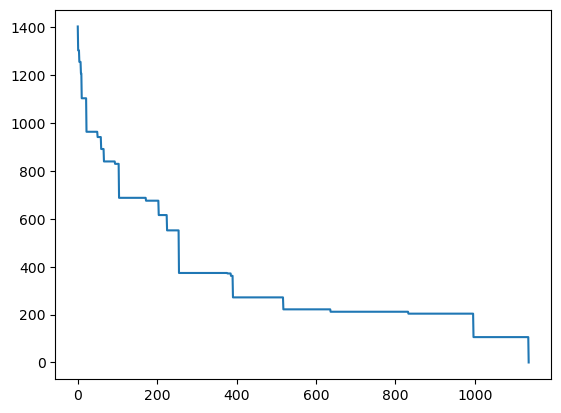

In [7]:
givens = np.array([
    [0, 0, 0, 7, 0, 2, 9, 0, 0],
    [0, 9, 0, 0, 8, 1, 2, 0, 0],
    [8, 7, 2, 4, 5, 0, 0, 1, 3],
    [1, 0, 0, 0, 7, 0, 4, 2, 0],
    [9, 0, 0, 1, 0, 5, 0, 0, 8],
    [0, 4, 0, 0, 0, 0, 5, 6, 0],
    [0, 3, 5, 8, 0, 4, 0, 9, 6],
    [0, 8, 0, 0, 3, 6, 7, 0, 0],
    [0, 0, 0, 5, 0, 0, 0, 3, 2],
]) #array of given numbers

movable_indices = [
    [i for i, val in enumerate(givens[row]) if val == 0]
    for row in range(9)
] #array of indices allowed to be mutated/crossovered
generation_amount = 2500
tournament_amount = 92 #here: pop_size - tournament_amount = elitism; must be <= pop_size
tournament_size = 8
epochs = 20 
pop_size = 100 #size of the population
probs = calc_probs(tournament_size) #array of probabilities for tournament selection
solved = False #bool for checking if a soultion was found
solution = Candidate(givens) 

for epoch in range(epochs):
    population = [Candidate(givens) for i in range(pop_size)] #initialize population
    losses = [] #array for storing losses for each generation for the plot
    for i in range(generation_amount):
        pop_cop = copy.deepcopy(population) #deepcopy to ensure no references are shared between individuals 
        winners = [tournament(rnd.sample(pop_cop,tournament_size), probs)
                   for i in range(tournament_amount)
                  ]
        crossover_winners(winners)
        mutate_winners(winners)

        population.sort(key=lambda x: x.loss)
        losses.append(population[0].loss) 
        if population[0].loss == 0.: #checks if the best candidate is a valid solution
            print('SOLUTION FOUND!')
            solution = population[0]
            solved = True
            break
        for j in range(len(winners)): #replaces original population with mutated and crossovered winners of the tournament starting with the ones with worst loss function
            population[-j-1].numbers = winners[j].numbers

        [instance.loss_function() for instance in population] #recalculates loss
        population.sort(key=lambda x: x.loss)
        current_loss = 1.
        for j in range(pop_size): #replaces duplicates with a random new candidate
            if current_loss == population[j].loss:
                population[j] = Candidate(givens) 
            else:
                current_loss = population[j].loss
    if solved: #if solved show plot
        print(solution.numbers)
        print(solution.loss)
        x_values = np.arange(len(losses))
        plt.plot(x_values, losses)
        plt.show()
        break
    print(population[0].numbers)
    print(population[0].loss)